In [2]:
import pandas as pd
import numpy as np
import json

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [3]:
# Load in our parameters file
with open('../parameters.json') as f:
    params = json.load(f)

In [4]:
# Get relevant parameters
database = params['database']
two_chunk_collection = params['chunk_2_collection']

# Connect to our database/collection
client = MongoClient('localhost', 27017)
db = client[database]
two_chunk_coll = db[two_chunk_collection]

In [5]:
chunk_df = pd.DataFrame(list(two_chunk_coll.find({},{'_id':0})))
chunk_df.head()

,avg_speed_chnk_1,avg_speed_chnk_2,mfn_sq_chnk_1,mfn_sq_chnk_2,seconds_chnk_1,seconds_chnk_2,start_timestamp,trip_id_iso
0,5.563081,5.117909,481636,452929,1250.0,1027.0,1.475912e+09,7253717_2016-10-08_4489K
1,5.051780,5.112077,12321,7396,1438.0,1428.0,1.475947e+09,7253845_2016-10-08_GHNYG
2,4.878015,3.558431,729,2916,1560.0,1806.0,1.475955e+09,7253837_2016-10-08_8Q6DP
3,4.676721,3.959559,28900,39204,1682.0,1550.0,1.475963e+09,7253830_2016-10-08_SR1KP
4,4.587672,3.931596,96100,114244,1678.0,1534.0,1.475972e+09,7253823_2016-10-08_TDW9M


In [6]:
mask = (chunk_df['seconds_chnk_1'] < 2500) & (chunk_df['seconds_chnk_2'] < 2500)
trimed_chnk_df = chunk_df[mask]

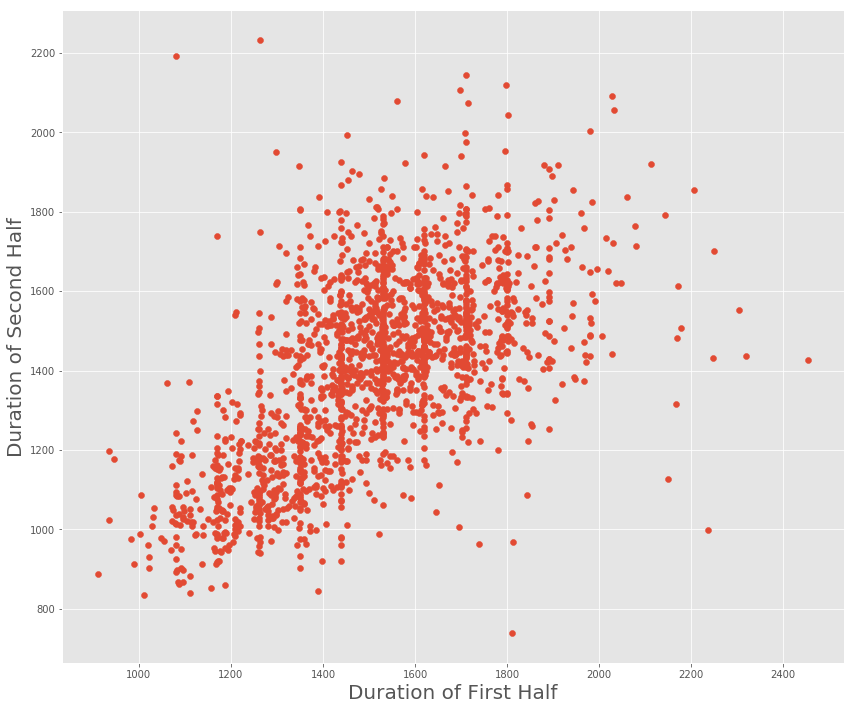

In [7]:
x = trimed_chnk_df['seconds_chnk_1'].values
y = trimed_chnk_df['seconds_chnk_2'].values

fig, ax = plt.subplots(figsize=(14, 12))
ax.scatter(x, y)
ax.set_xlabel("Duration of First Half", fontsize=20)
ax.set_ylabel("Duration of Second Half", fontsize=20)
plt.savefig('chunk_2_prior.jpg');

In [8]:
sort_df = chunk_df.sort_values('start_timestamp')
sort_df.reset_index(drop=True, inplace=True)

data_with_priors = []

for idx, row in sort_df.iterrows():

    if idx != 0:
        
        data_dict = {}
        
        prior = sort_df.iloc[idx-1]
        
        current_ts = row['start_timestamp']
        prior_ts = prior['start_timestamp']
        
        diff =  current_ts - prior_ts
        
        if diff < 1800:
            
            data_dict['seconds_chnk_1'] = row['seconds_chnk_1']
            data_dict['seconds_chnk_2'] = row['seconds_chnk_2']
            data_dict['mfn_sq_chnk_1'] = row['mfn_sq_chnk_1']
            data_dict['prior_seconds_chnk_2'] = prior['seconds_chnk_2']
            
            data_with_priors.append(data_dict)
            
prior_df = pd.DataFrame(data_with_priors)

mask = (prior_df['prior_seconds_chnk_2'] < 2500) & (prior_df['seconds_chnk_2'] < 2500)
prior_trimed_df = prior_df[mask]

prior_trimed_df.head()

,mfn_sq_chnk_1,prior_seconds_chnk_2,seconds_chnk_1,seconds_chnk_2
0,481636,1062.0,1250.0,1027.0
1,36481,1525.0,1494.0,1396.0
2,2401,1295.0,1603.0,1350.0
3,900,1350.0,1904.0,1326.0
4,121,1326.0,1617.0,1366.0


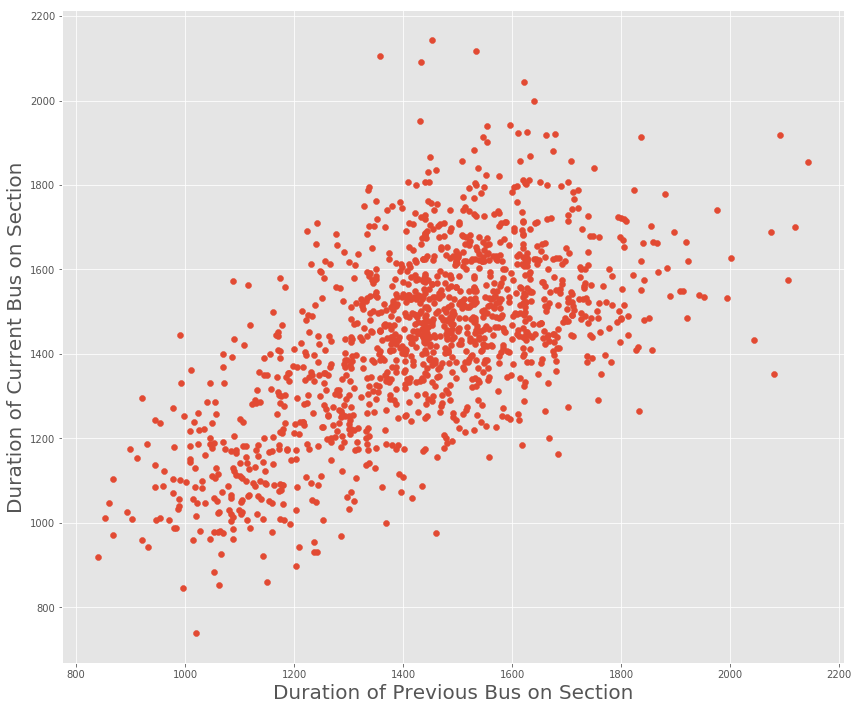

In [9]:
y = prior_trimed_df['seconds_chnk_2'].values.reshape(-1,1)
x = prior_trimed_df['prior_seconds_chnk_2'].values.reshape(-1,1)

fig, ax = plt.subplots(figsize=(14, 12))
ax.scatter(x, y)
ax.set_xlabel("Duration of Previous Bus on Section", fontsize=20)
ax.set_ylabel("Duration of Current Bus on Section", fontsize=20);
plt.savefig('chunk_2_previous.jpg');